In [1]:
from models import LlamaForCausalLMNew
from transformers import AutoTokenizer, LlamaConfig
import torch
from datasets import load_dataset

/usr/scratch/haokang/anaconda3/envs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model_id = "meta-llama/Llama-2-7b-hf"
# config = LlamaConfig.from_pretrained(
#     model_id,
#     use_auth_token=True,
#     token=None,
#     use_flash_attn=False,
# )
model_kwargs = {}
model_kwargs["torch_dtype"] = torch.float16
model_kwargs["device_map"] = "auto"
model_kwargs["token"] = None
model_kwargs["cache_dir"] = "../cache"

In [ ]:
model = LlamaForCausalLMNew.from_pretrained(
    model_id,
    # config=config,
    **model_kwargs,
    # cache_dir="../cache",
    # compress_config=None,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    token=None,
    padding_side="left",
    model_max_length=256,
    use_fast=False,
    cache_dir="../cache",
)
tokenizer.pad_token = tokenizer.eos_token

In [2]:
eval_dataset = load_dataset("gsm8k", "main", split="test")
# print(eval_dataset[0])
with open(f"./prompt_original.txt", "r") as handle:
    prompt_cot = handle.read()
    
questions = eval_dataset[0]["question"]
answers = eval_dataset[0]["answer"]
prompts = [
            prompt_cot + "\nQuestion: " + question + "\n" for question in questions
        ]
inputs = tokenizer(
    prompts,
    return_tensors="pt",
    padding="longest",
    truncation=True,
)
print(len(prompts))

280


In [ ]:

inputs = inputs.to("cuda")
print(inputs["input_ids"].shape)

In [ ]:
generated = model(**inputs,use_cache=True)

In [51]:
import torch
from compress_function import fake_dense_sparse_uniformquantization
tensor = torch.load("key_states.pt")
print(tensor.shape)

torch.Size([1, 32, 256, 128])


In [52]:
from compress_function import fake_uniformquantization
quant_error = []
x0 = []
for i in torch.range(1,16):
    quantized_tensor = fake_uniformquantization(tensor, i)
    error = torch.norm(tensor - quantized_tensor)
    quant_error.append(error)
    x0.append(16/i)
print(quant_error)

[tensor(6285.5220), tensor(1762.0299), tensor(636.6998), tensor(275.9793), tensor(130.2408), tensor(63.8986), tensor(31.7246), tensor(15.8723), tensor(8.0512), tensor(4.2872), tensor(2.5904), tensor(1.9565), tensor(1.7699), tensor(1.7309), tensor(1.7243), tensor(1.7234)]


/tmp/ipykernel_1489956/255247470.py:4: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for i in torch.range(1,16):


In [56]:
x1 = []
def fake_sparsity(input_tensor, keep_rate):
    sorted_value = torch.sort(torch.abs(input_tensor), descending=True).values
    sorted_value[0:int(sorted_value.shape[0] * keep_rate)] = 0.0
    return sorted_value

tensor1 = tensor.reshape(-1)
sparsity_error = []

for i in torch.arange(0.01, 1.01, 0.01).tolist():  # Convert torch.Tensor to Python list
    sparsity_tensor = fake_sparsity(tensor1.clone(), i)
    error = torch.norm(sparsity_tensor)
    sparsity_error.append(error)
    x1.append(1/i)
print(sparsity_error)

[tensor(925.5000, dtype=torch.float16), tensor(876.5000, dtype=torch.float16), tensor(837., dtype=torch.float16), tensor(802., dtype=torch.float16), tensor(771., dtype=torch.float16), tensor(742.5000, dtype=torch.float16), tensor(716.5000, dtype=torch.float16), tensor(692., dtype=torch.float16), tensor(669., dtype=torch.float16), tensor(647., dtype=torch.float16), tensor(626.5000, dtype=torch.float16), tensor(606.5000, dtype=torch.float16), tensor(587.5000, dtype=torch.float16), tensor(569.5000, dtype=torch.float16), tensor(552., dtype=torch.float16), tensor(535.5000, dtype=torch.float16), tensor(519., dtype=torch.float16), tensor(503.5000, dtype=torch.float16), tensor(488.5000, dtype=torch.float16), tensor(474., dtype=torch.float16), tensor(460., dtype=torch.float16), tensor(446.2500, dtype=torch.float16), tensor(433., dtype=torch.float16), tensor(420.2500, dtype=torch.float16), tensor(407.7500, dtype=torch.float16), tensor(395.7500, dtype=torch.float16), tensor(384., dtype=torch.floa

In [54]:
print(tensor.shape)
tensor2 = tensor.reshape(256,-1).float()
low_rank_error = []
x2 = []
print(tensor2.shape)
for i in torch.arange(1,256):
    U,S,V = torch.svd_lowrank(tensor2,i)
    quantized_tensor = torch.matmul(torch.matmul(U,torch.diag(S)),V.T)
    error = torch.norm(tensor2 - quantized_tensor)
    low_rank_error.append(error)
    x2.append(256*4096/(i*(256+4096)))
print(low_rank_error)
print(x2)

torch.Size([1, 32, 256, 128])
torch.Size([256, 4096])
[tensor(978.2054), tensor(954.0850), tensor(941.8173), tensor(918.3443), tensor(893.7125), tensor(887.0356), tensor(864.1527), tensor(850.3834), tensor(836.0349), tensor(826.8486), tensor(809.1646), tensor(801.7950), tensor(793.2534), tensor(775.9822), tensor(763.8463), tensor(759.2917), tensor(746.3121), tensor(733.5262), tensor(728.2086), tensor(715.0130), tensor(707.5002), tensor(698.7420), tensor(687.5624), tensor(679.4258), tensor(670.6833), tensor(662.7347), tensor(653.3987), tensor(644.1480), tensor(637.0336), tensor(627.8423), tensor(619.7821), tensor(614.0818), tensor(605.3847), tensor(598.1077), tensor(590.4360), tensor(580.9718), tensor(574.4700), tensor(567.9916), tensor(561.1259), tensor(555.7212), tensor(546.7112), tensor(543.4769), tensor(536.0704), tensor(528.6879), tensor(520.4829), tensor(516.0076), tensor(508.1725), tensor(503.4382), tensor(496.1025), tensor(493.1588), tensor(483.6813), tensor(481.3032), tensor(47

[tensor(16.), tensor(8.), tensor(5.3333), tensor(4.), tensor(3.2000), tensor(2.6667), tensor(2.2857), tensor(2.), tensor(1.7778), tensor(1.6000), tensor(1.4545), tensor(1.3333), tensor(1.2308), tensor(1.1429), tensor(1.0667), tensor(1.)]
[100.00000223517424, 50.00000111758712, 33.33333407839141, 25.00000055879356, 20.000001192092967, 16.666667039195705, 14.28571422489322, 12.50000027939678, 11.111110669595242, 9.99999985098839, 9.090909140169128, 8.333333002196431, 7.692307974459867, 7.14285711244661, 6.666666401757145, 6.25000013969839, 5.882352879303138, 5.555555334797621, 5.263157960780771, 4.999999925494195, 4.761904572683675, 4.545454570084564, 4.347826008084592, 4.166666759798926, 4.0, 3.8461539872299335, 3.7037035565317473, 3.571428556223305, 3.4482759612919205, 3.3333332008785725, 3.225806426803478, 3.125000069849195, 3.0303029098896115, 2.941176439651569, 2.857142662515459, 2.7777776673988104, 2.7027026678716473, 2.6315787740031222, 2.5641024622142865, 2.4999999627470975, 2.43

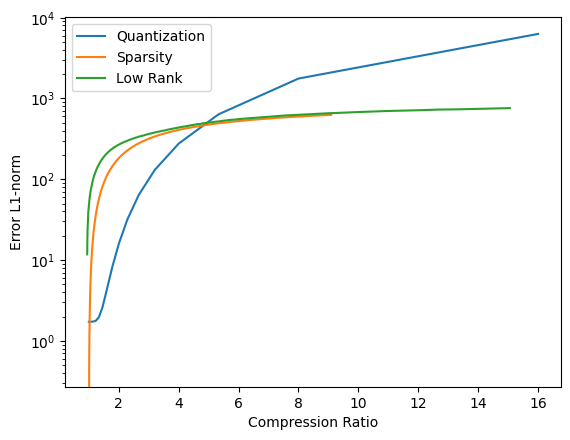

In [61]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# 创建三个一维张量


# 创建X轴数据
# x0 = torch.arange(1,17)
# x1 = torch.arange(0, len(sparsity_error))
# x2 = torch.arange(1, len(low_rank_error) + 1)
# x0 = x0 / 16
# x1 = x1 /10
# print(x1)
# x2 = x2 /256
# # 绘制折线图
# x0 = 1/ x0
# x1 = 1/ x1
# x2 = 1/ x2
print(x0)
print(x1)
print(x2)
plt.plot(x0, quant_error, label='Quantization')
plt.plot(x1[-90:], sparsity_error[-90:], label='Sparsity')
plt.plot(x2[-240:], low_rank_error[-240:], label='Low Rank')

# 添加轴标签和图例
plt.xlabel('Compression Ratio')
plt.ylabel('Error L1-norm')
plt.yscale('log')
plt.legend()

# 显示图像
plt.show()

In [66]:
print(tensor.shape)

x3_group = []
outlier_error_group = []
from compress_function import fake_dense_sparse_uniformquantization
for i in torch.arange(1, 9, 1).tolist():
    x3 = []
    outlier_error = []
    for j in torch.arange(0.01, 0.21, 0.01).tolist():
        quantized_tensor = fake_dense_sparse_uniformquantization(tensor, i, j)
        error = torch.norm(tensor - quantized_tensor)
        outlier_error.append(error)
        x3.append(1/(i/16+3*j))
    x3_group.append(x3)
    outlier_error_group.append(outlier_error)
print(outlier_error)
print(x3)

torch.Size([1, 32, 256, 128])
[tensor(7.5454), tensor(6.4034), tensor(5.7995), tensor(5.3437), tensor(5.0094), tensor(4.7335), tensor(4.4916), tensor(4.2860), tensor(4.1137), tensor(3.9526), tensor(3.8063), tensor(3.6852), tensor(3.5591), tensor(3.4467), tensor(3.3383), tensor(3.2496), tensor(3.1497), tensor(3.0690), tensor(2.9891), tensor(2.9195)]
[1.8867924552173452, 1.785714289990767, 1.6949152600162505, 1.6129032327841026, 1.5384615596229512, 1.4705882439950553, 1.4084507024517563, 1.351351361147586, 1.2987012806057752, 1.2499999930150807, 1.204819279704078, 1.1627906783327278, 1.123595523677711, 1.0869565196264894, 1.0526315591341904, 1.0204081744365225, 0.9900990046422723, 0.9615384416996379, 0.9345794454996571, 0.9090909017019037]


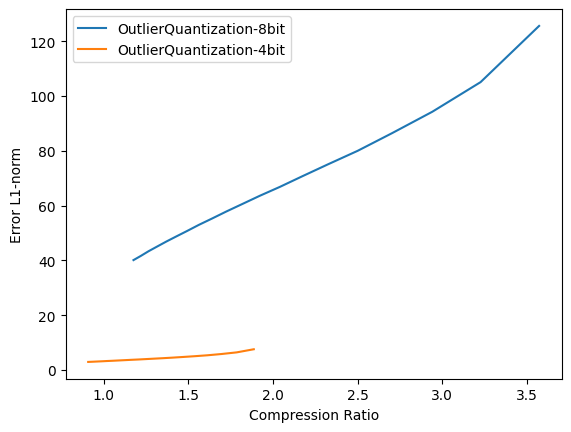

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# 创建三个一维张量


# 创建X轴数据
# x0 = torch.arange(1,17)
# x1 = torch.arange(0, len(sparsity_error))
# x2 = torch.arange(1, len(low_rank_error) + 1)
# x0 = x0 / 16
# x1 = x1 /10
# print(x1)
# x2 = x2 /256
# # 绘制折线图
# x0 = 1/ x0
# x1 = 1/ x1
# x2 = 1/ x2

plt.plot(x3_group[3][:], outlier_error_group[3][:], label='OutlierQuantization-8bit')
plt.plot(x3_group[7][:], outlier_error_group[7][:], label='OutlierQuantization-4bit')

# 添加轴标签和图例
plt.xlabel('Compression Ratio')
plt.ylabel('Error L1-norm')
# plt.yscale('log')
plt.legend()

# 显示图像
plt.show()

In [2]:
import torch
tensor = torch.load("key_states.pt")
# tensor = tensor.reshape(256,-1).float()
from compress_function import fake_outquant_with_lrap_svd
x4_group = []
outlrap_error_group = []
for i in torch.arange(0.01,0.11,0.01).tolist():
    #outlier
    x4 = []
    outlrap_error = []
    for j in torch.arange(0.01,0.11,0.01).tolist():
        # rank
        
        j = int(256*j)
        quantized_tensor = fake_outquant_with_lrap_svd(tensor, 4,j,3,i)
        error = torch.norm(tensor - quantized_tensor)
        outlrap_error.append(error)
        original_size = 256*4096
        x4.append(original_size/(original_size*0.25+original_size*3*i+j*(256+4095)))
    x4_group.append(x4)
    outlrap_error_group.append(outlrap_error)
print(outlrap_error[0])
print(x4[0])

tensor(60.2257)
1.791155308992399


[3.4686226442494283, 3.3250519137843937, 3.235763648054746, 3.1104743875288072, 3.0322028180410467, 2.9219128697588137, 2.8527380055913185, 2.754906404437092, 2.6635623792156737, 2.6059587852253983]


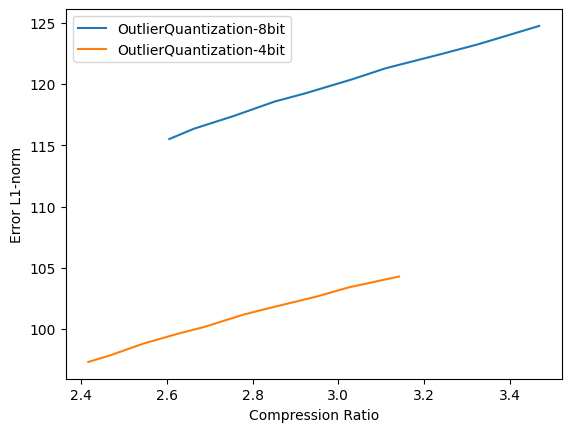

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# 创建三个一维张量


# 创建X轴数据
# x0 = torch.arange(1,17)
# x1 = torch.arange(0, len(sparsity_error))
# x2 = torch.arange(1, len(low_rank_error) + 1)
# x0 = x0 / 16
# x1 = x1 /10
# print(x1)
# x2 = x2 /256
# # 绘制折线图
# x0 = 1/ x0
# x1 = 1/ x1
# x2 = 1/ x2
print(x4_group[0][:])
plt.plot(x4_group[0][:], outlrap_error_group[0][:], label='OutlierQ_withLRAP-4bit-0.01')
plt.plot(x4_group[1][:], outlrap_error_group[1][:], label='OutlierQ_withLRAP-4bit-0.02')

# 添加轴标签和图例
plt.xlabel('Compression Ratio')
plt.ylabel('Error L1-norm')
# plt.yscale('log')
plt.legend()

# 显示图像
plt.show()